In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
sys.path.append('../../')

from skyburst.plot import *
from skyburst import utils

# Plotting Code for Helios End2End

In [2]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(right=3)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Load (s)',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

legend_dict = {
    ('constant', -1, -1): 'Constant-Wait',
    ('constant', 0.25, -1): 'Constant-Wait + No-SJ',
    ('linear_capacity_filter_cpu', -1, -1): 'Resource-Wait',
    ('linear_cost_filter_cpu', -1, -1): 'Starburst',
    ('linear_capacity_filter_cpu', 0.25, 3): 'Starburst (No-TE)',
    ('zero', -1, -1): 'No-Wait',
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Starburst': 'tab:red',
    'Constant-Wait + No-SJ': 'tab:green',
    'Starburst (No-TE)': 'tab:purple',
    'Resource-Wait': 'tab:pink',
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)

    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time.
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                # Hardcoded, precomputed ahead of time.
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'

    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return 100* (1 - (cost/baseline_cost)) #max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        # 1 V100 GPU costs 2.5$/hour. So far, everything is normalized to 1.
        return 2.5*(baseline_cost - cost)

    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','s', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        if label[0] == 'zero' and label[1] !=-1:
            continue
        if label not in legend_dict:
            continue
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
            if ax_idx < 2 and label=='No-Wait':
                continue
            color = color_dict[label]
            print(label)
            if label == 'Starburst (No-TE)':
                pd.set_option('display.max_rows', None)
                print(grp['cost_mult'].to_string())
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, color=color, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()
    # print(labels)
    assert len(lines) == 5
    fig.legend([lines[4], lines[0], lines[1], lines[2], lines[3]], 
               [labels[4], labels[0], labels[1], labels[2], labels[3]], bbox_to_anchor=(0, 0.92, 1, 0.2),  ncol=len(labels),loc='upper center')
    plt.tight_layout()
    plt.savefig('../../simulators/figures/evaluation/helios.pdf', bbox_inches='tight')
    plt.show()  

In [3]:

helios_df = utils.load_logs_as_dataframe('/home/gcpuser/final_logs/eval/helios_end2end.log')

Constant-Wait
Constant-Wait
Constant-Wait
Constant-Wait
Constant-Wait + No-SJ
Constant-Wait + No-SJ
Constant-Wait + No-SJ
Constant-Wait + No-SJ
Starburst (No-TE)
4       2.669191
9       3.854692
14      4.940480
19      7.503763
24      9.116087
29     13.521535
34     15.953798
39     16.821367
44     26.226767
49     36.669363
54     46.634563
59     49.917993
64     59.579756
69     64.866737
74     65.438990
79     74.767633
84     79.118376
89     84.638581
94     97.124959
99     93.155793
104    99.008391
109     0.000000
114     0.000000
119     0.000000
124     0.000000
129     0.000000
134     0.000000
139     0.000000
144     0.000000
149     0.000000
154     0.000000
159     0.000000
Starburst (No-TE)
4       2.669191
9       3.854692
14      4.940480
19      7.503763
24      9.116087
29     13.521535
34     15.953798
39     16.821367
44     26.226767
49     36.669363
54     46.634563
59     49.917993
64     59.579756
69     64.866737
74     65.438990
79     74.767633
84  

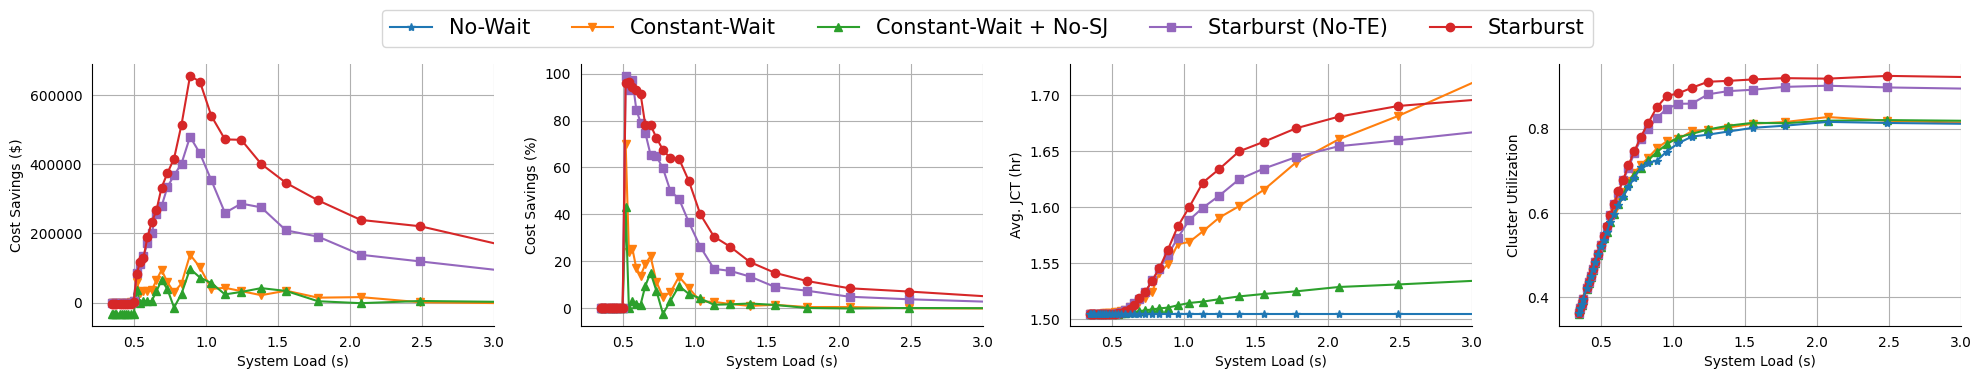

In [4]:
simulator_plotting_fn(helios_df, x_axis='cluster_size',  \
                      y_axis=['cost_diff','cost_mult','avg_jct','cluster_utilization'], \
                      baseline_filter={'waiting_policy': 'zero',},
                      # Groups baselines by waiting_policy x long_job_thres x preempt_cloud_ratio
                      groupby_values=['waiting_policy', 'long_job_thres', 'preempt_cloud_ratio'],
                      normalize_x_axis=True) # Normalizes x-axis to system utilization.

# Plotting Code for Philly End2End

In [5]:

philly_df = utils.load_logs_as_dataframe('/home/gcpuser/final_logs/eval/philly_end2end.log')

In [6]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(right=3)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': 'Cost Savings (%)',
    'cost_diff': 'Cost Savings ($)',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Load (s)',
    'system_utilization': 'System Load (s)',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}


legend_dict = {
    ('constant', -1, -1): 'Constant-Wait',
    ('constant', 0.25, -1): 'Constant-Wait + No-SJ',
    ('linear_capacity', -1, -1): 'Resource-Wait',
    ('linear_cost', -1, -1): 'Starburst',
    ('linear_capacity', 0.25, 3): 'Starburst (No-TE)',
    ('zero', -1, -1): 'No-Wait',

}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Starburst': 'tab:red',
    'Constant-Wait + No-SJ': 'tab:green',
    'Starburst (No-TE)': 'tab:purple',
    'Resource-Wait': 'tab:pink',
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)

    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'

    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait, happens at low system load (we should ignore this as this contains a lot of errors.)
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return 100* (1 - (cost/baseline_cost)) #max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
#         if 2.5*(baseline_cost - cost) > 100000:
#             print(row['cluster_size'], row['cost_mult'], row['system_utilization_x'])
        return 2.5*(baseline_cost - cost)

    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
#     diff_df['frag_ratio'] = diff_df.apply(fragmentation_fraction, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','s', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        if label[0] == 'zero' and label[1] !=-1:
            continue
        if label not in legend_dict:
            continue
        label = legend_dict[label]
        for ax_idx, ax in enumerate(axs):
            if ax_idx < 2 and label=='No-Wait':
                continue
            color = color_dict[label]
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, color=color, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    lines, labels = ax.get_legend_handles_labels()

    fig.legend([lines[4], lines[0], lines[1], lines[2], lines[3]], 
               [labels[4], labels[0], labels[1], labels[2], labels[3]], bbox_to_anchor=(0, 0.92, 1, 0.2),  ncol=len(labels),loc='upper center')
    plt.tight_layout()
    plt.savefig('../../simulators/figures/evaluation/philly.pdf', bbox_inches='tight')
    plt.show()  

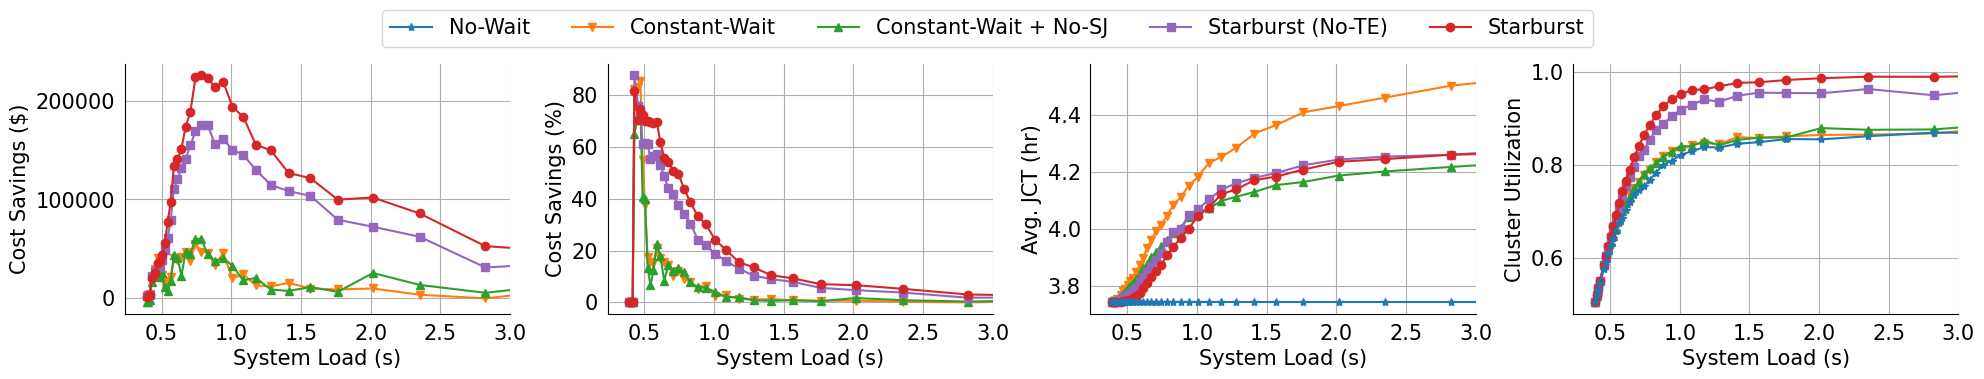

In [7]:

simulator_plotting_fn(philly_df, x_axis='cluster_size',  \
                      y_axis=['cost_diff','cost_mult','avg_jct','cluster_utilization'], \
                      baseline_filter={'waiting_policy': 'zero', 'long_job_thres': -1, 'loop': 0},
                      groupby_values=['waiting_policy', 'long_job_thres', 'preempt_cloud_ratio'],
                      normalize_x_axis=True)

# Plotting Code for Philly Pareto Curve

In [8]:
# Pareto curves
philly_pareto_df = utils.load_logs_as_dataframe('/home/gcpuser/final_logs/eval/philly_pareto.log')

In [9]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(left=4, right=6)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    ('constant', -1, -1): 'Constant-Wait',
    ('constant', 0.25, -1): 'Constant-Wait + No-SJ',
    ('zero', -1, -1): 'No-Wait',
    ('linear_cost', -1, -1): 'Starburst',
    ('linear_capacity', 0.25, 3): 'Starburst (No-TE)',
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Starburst': 'tab:red',
    'Constant-Wait + No-SJ': 'tab:green',
    'Starburst (No-TE)': 'tab:purple'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100* (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)

    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        label = legend_dict[label]
        color = color_dict[label]
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], ax = ax, label = label, color=color, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    for row in diff_df.iterrows():
        row = row[1]
        temp=False
        if row['waiting_policy_x'] == 'constant' and row['waiting_factor_x'] == 1 and row['long_job_thres_x']== -1:
            color = 'tab:orange'
            temp=True
            marker = 'P'
            marker_size = 13
        elif row['waiting_policy_x'] == 'constant' and row['waiting_factor_x'] == 1 and row['long_job_thres_x']== 0.25:
            color = 'tab:green'
            temp=True
            marker = 's'
            marker_size = 10
        elif row['waiting_policy_x'] == 'linear_cost' and row['waiting_factor_x'] == 0.08:
            color = 'tab:red'
            temp=True
            marker = '*'
            marker_size = 18
        elif row['waiting_policy_x'] == 'linear_capacity' and row['waiting_factor_x'] == 0.8:
            color = 'tab:purple'
            temp=True
            marker = 'o'
            marker_size = 12

        if temp:
            plt.plot(row['avg_jct_x'], row['norm_cloud_cost'], marker=marker, markersize=marker_size, markeredgecolor=color, markerfacecolor=color)
    
    plt.plot(4.065, 1, marker="X", markersize=13, markeredgecolor='tab:blue', markerfacecolor='tab:blue', label='No-Wait')
    
    _, labels = ax.get_legend_handles_labels()
    print(labels)
    from matplotlib.lines import Line2D
    fig.legend([Line2D([0], [0], marker='P', color='tab:orange', markerfacecolor='tab:orange', \
            markersize=13, markeredgecolor='tab:orange', label='Constant-Wait'), \
            Line2D([0], [0], marker='s', color='tab:green', markerfacecolor='tab:green', \
            markersize=10, markeredgecolor='tab:green', label='Constant-Wait + No-SJ'), \
            Line2D([0], [0], marker='o', color='tab:purple', markerfacecolor='tab:purple', \
            markersize=12, markeredgecolor='tab:purple', label='Starburst (NoTE)'), \
             Line2D([0], [0], marker='*', color='tab:red', markerfacecolor='tab:red', \
            markersize=18, markeredgecolor='tab:red', label='Starburst'), \
            Line2D([0], [0], marker='X', color='w', markerfacecolor='tab:blue', \
            markersize=13, markeredgecolor='tab:blue', label='No-Wait') ], labels, ncol=1,loc='lower right', bbox_to_anchor=(0.94, 0.25), framealpha=0.6)
    
    
    plt.tight_layout()
    plt.savefig('../../simulators/figures/evaluation/philly_pareto.pdf', bbox_inches='tight')
    plt.show()

['Constant-Wait', 'Constant-Wait + No-SJ', 'Starburst (No-TE)', 'Starburst', 'No-Wait']


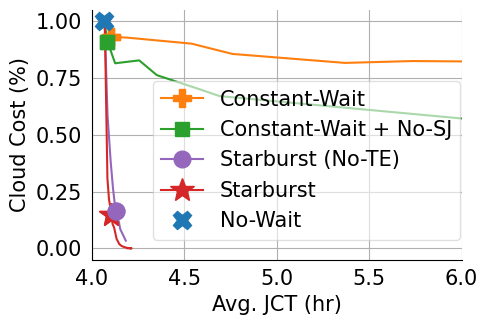

In [10]:
    
simulator_plotting_fn(philly_pareto_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'constant','waiting_factor': 0, },
                      groupby_values=['waiting_policy', 'long_job_thres', 'preempt_cloud_ratio'],
                      normalize_x_axis=True)

# Plotting Code for Helios Pareto Curve

In [11]:
# Pareto curves
helios_pareto_df = utils.load_logs_as_dataframe('/home/gcpuser/final_logs/eval/helios_pareto.log')

In [12]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(left=1.48, right=4)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
    'norm_cloud_cost': 'Cloud Cost (%)'
}

legend_dict = {
    ('constant', -1, -1): 'Constant-Wait',
    ('constant', 0.25, -1): 'Constant-Wait + No-SJ',
    ('zero', -1, -1): 'No-Wait',
    ('linear_cost_filter_cpu', -1, -1): 'Starburst',
    ('linear_capacity_filter_cpu', 0.25, 3): 'Starburst (No-TE)',
}

color_dict = {
    'No-Wait': 'tab:blue',
    'Constant-Wait': 'tab:orange',
    'Starburst': 'tab:red',
    'Constant-Wait + No-SJ': 'tab:green',
    'Starburst (No-TE)': 'tab:purple'
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    axs = [axs]
    for k,v in df_filter.items():
        df = df[df[k]==v]
        
    
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert not isinstance(v, list)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on='arrival_rate',right_on='arrival_rate')
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            if df['dataset'].iloc[0] == 'philly':
                total_job_volume = 1155998.77277777
                job_makespan = 2559.3205555555555
            elif df['dataset'].iloc[0] == 'helios':
                total_job_volume = 1853756.1241666232
                job_makespan = 4651.911388888889
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return max(0, 100 * (1 - (cost/baseline_cost)))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['norm_cloud_cost'] = diff_df['total_cloud_cost_x']/diff_df['total_cloud_cost_x'].max()
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)

    groupby_values = [f'{g}_x' if g!='arrival_rate' else g for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' and y!='arrival_rate' and y!='norm_cloud_cost' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        label = legend_dict[label]
        color = color_dict[label]
        for ax_idx, ax in enumerate(axs):   
            grp.plot(x = x_axis + '_x', y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], ax = ax, label = label, color=color, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)

    for row in diff_df.iterrows():
        row = row[1]
        temp=False
        if row['waiting_policy_x'] == 'constant' and row['waiting_factor_x'] == 1 and row['long_job_thres_x']== -1:
            color = 'tab:orange'
            temp=True
            marker = 'P'
            marker_size = 13
        elif row['waiting_policy_x'] == 'constant' and row['waiting_factor_x'] == 1 and row['long_job_thres_x']== 0.25:
            color = 'tab:green'
            temp=True
            marker = 's'
            marker_size = 10
        elif row['waiting_policy_x'] == 'linear_cost_filter_cpu' and row['waiting_factor_x'] == 0.08:
            color = 'tab:red'
            temp=True
            marker = '*'
            marker_size = 18
        elif row['waiting_policy_x'] == 'linear_capacity_filter_cpu' and row['waiting_factor_x'] == 0.25:
            color = 'tab:purple'
            temp=True
            marker = 'o'
            marker_size = 12
        if temp:
            plt.plot(row['avg_jct_x'], row['norm_cloud_cost'], marker=marker, markersize=marker_size, markeredgecolor=color, markerfacecolor=color)
    
    plt.plot(1.56, 1, marker="X", markersize=13, markeredgecolor='tab:blue', markerfacecolor='tab:blue', label='No-Wait')
    
    lines, labels = ax.get_legend_handles_labels()

    from matplotlib.lines import Line2D
    fig.legend([Line2D([0], [0], marker='P', color='tab:orange', markerfacecolor='tab:orange', \
            markersize=12, markeredgecolor='tab:orange', label='Constant-Wait'), \
            Line2D([0], [0], marker='s', color='tab:green', markerfacecolor='tab:green', \
            markersize=9, markeredgecolor='tab:green', label='Constant-Wait + No-SJ'), \
            Line2D([0], [0], marker='o', color='tab:purple', markerfacecolor='tab:purple', \
            markersize=12, markeredgecolor='tab:purple', label='Starburst (NoTE)'), \
             Line2D([0], [0], marker='*', color='tab:red', markerfacecolor='tab:red', \
            markersize=17, markeredgecolor='tab:red', label='Starburst'), \
            Line2D([0], [0], marker='X', color='w', markerfacecolor='tab:blue', \
            markersize=12, markeredgecolor='tab:blue', label='No-Wait') ], labels, ncol=1,loc='lower right', bbox_to_anchor=(0.94, 0.42), framealpha=0.6)
    
    
    plt.tight_layout()
    plt.savefig('../../simulators/figures/evaluation/helios_pareto.pdf', bbox_inches='tight')
    plt.show()

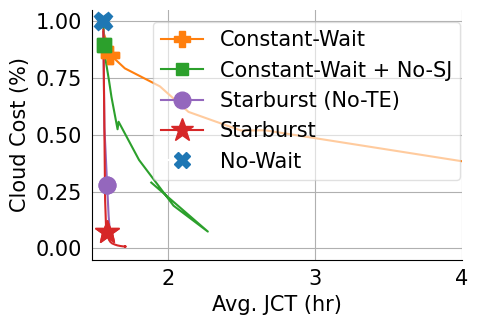

In [13]:
simulator_plotting_fn(helios_pareto_df, x_axis='avg_jct',  \
                      y_axis=['norm_cloud_cost'], \
                      baseline_filter={'waiting_policy': 'constant','waiting_factor': 0, },
                      groupby_values=['waiting_policy', 'long_job_thres', 'preempt_cloud_ratio'],
                      normalize_x_axis=True)